In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np

np.float64(95.99553092424617)

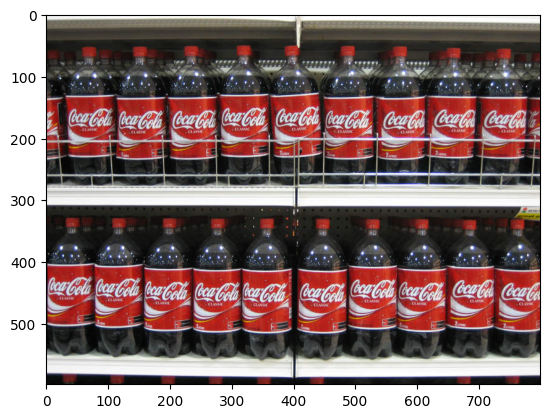

In [3]:
coca_multi = cv.cvtColor(cv.imread('images/coca_multi.png'), cv.COLOR_BGR2RGB)
plt.imshow(coca_multi)
np.mean(coca_multi)

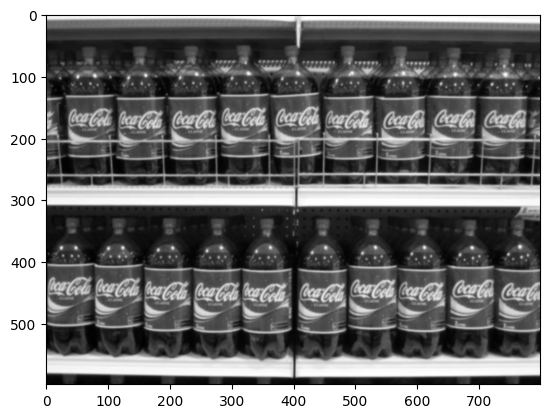

In [237]:
def filter_closed_loops(gray):
    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary)
    for contour in contours:
        if not cv.isContourConvex(contour):
            if cv.arcLength(contour, cv.isContourConvex(contour)) > 100 and cv.contourArea(contour) > 20:
                cv.drawContours(mask, [contour], -1, 255, thickness=cv.FILLED)
    filtered_image = cv.bitwise_and(binary, mask)
    return filtered_image
    
def preprocess(image, kernel_size=5, threshold_1=100, threshold_2=200):
    grayscale = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if len(image.shape) == 3 else image.copy()
    blurred = cv.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
    canny_edges = cv.Canny(blurred, threshold_1, threshold_2)
    canny_edges_after_blur = cv.Canny(blurred,threshold_1, threshold_2)
    kernel = np.ones((3, 3), np.uint8) 
    filtered = filter_closed_loops(canny_edges_after_blur)
    return grayscale, blurred, canny_edges, canny_edges_after_blur, filtered

def preprocess_(image, kernel_size=5, threshold_1=100, threshold_2=200):
    return preprocess(image, kernel_size, threshold_1, threshold_2)[4]

def preprocess_blur(image, kernel_size=5, threshold_1=100, threshold_2=200):
    return preprocess(image, kernel_size, threshold_1, threshold_2)[1]

grayscale, blurred, canny_edges, canny_edges_after_blur,filtered = preprocess(coca_multi, kernel_size=5)
plt.imshow(blurred, cmap='gray')

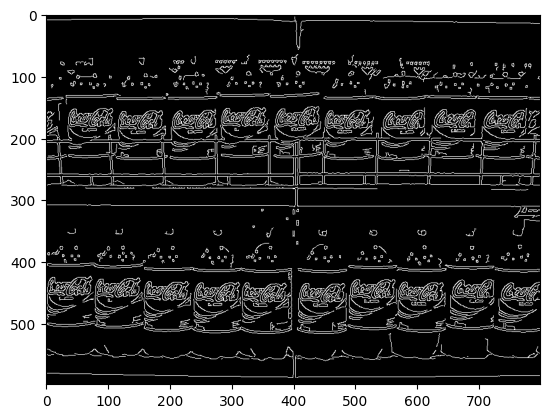

In [5]:
plt.imshow(canny_edges, cmap='gray')

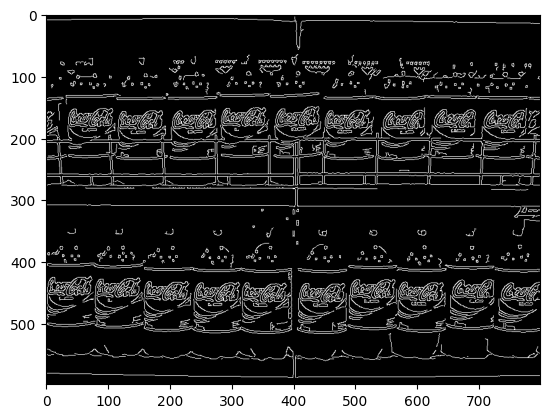

In [6]:
plt.imshow(canny_edges_after_blur, cmap='gray')

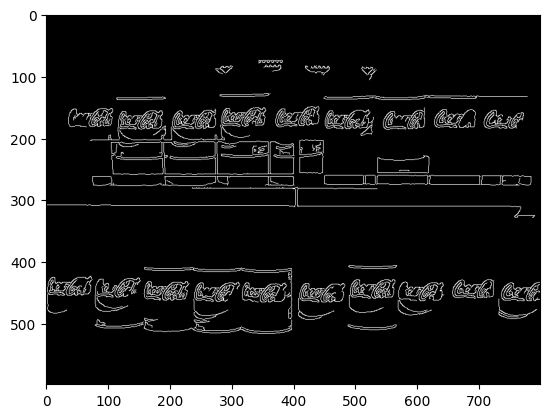

In [238]:
plt.imshow(filtered, cmap='gray')

2.9166666666666665

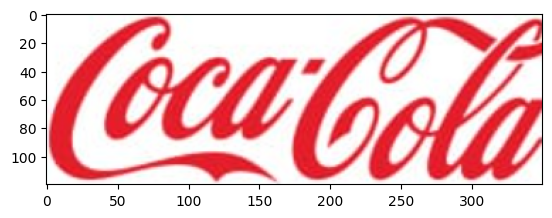

In [8]:
template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
template_reduced = template[30:-25, 10:-40]
plt.imshow(template_reduced)
aspect_ratio = template_reduced.shape[1]/template_reduced.shape[0]
aspect_ratio

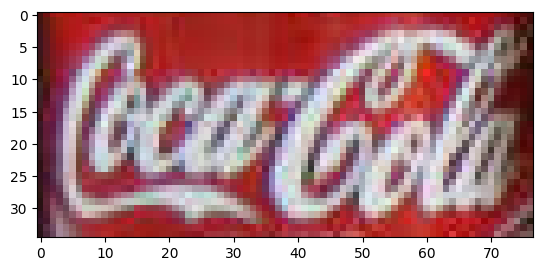

In [9]:
some_other = coca_multi.copy()
some_other = some_other[150:185,33:110,:]
plt.imshow(some_other)

In [10]:
some_other.shape

(35, 77, 3)

In [11]:
aspect_ratio = some_other.shape[1]/some_other.shape[0]
aspect_ratio

2.2

In [334]:
# esta es resizeando la img original
import imutils
import numpy as np

test_images = os.listdir('images')
test_images_paths = [f'images/{im}' for im in test_images]
test_images_color = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in test_images_paths]

def plot_images(img_list, img_names, method='', cols=3):
    rows = len(img_list)//cols + 1
    f, axes = plt.subplots(rows,cols, figsize=(20,15)) 
    axes = axes.flatten()
    
    for i,ax in enumerate(axes):
        if i < len(img_list):
            ax.imshow(img_list[i])
            ax.set_title(f'{img_names[i]} {method}')
        else:
            ax.axis('off')


def normalize(x, xmax, xmin):
    return (x - xmin) / (xmax - xmin)

def detect_logo(image_rgb, method, threshold=0.80):
    template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
    template_reduced = template[30:-25, 10:-15]
    edged_template = preprocess_(template_reduced)
    
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    tW, tH = edged_template.shape[::-1]
    found = {}    
    all_results = np.array([], dtype=np.float32)

    
    # resized_images = [] 
    # curr_img = gray.copy()
    # for i in range(3):
    #     curr_img = cv.pyrDown(curr_img)    
    #     resized_images.append(curr_img)
    # resized_images.append(gray)
    # curr_img = gray.copy()
    # for i in range(3):
    #     curr_img = cv.pyrUp(curr_img)    
    #     resized_images.append(curr_img)

    # for i, resized in enumerate(resized_images):
    #     print(f'procesing piramid {100*(i+1)/len(resized_images)}%' )
    #     r = gray.shape[1] / float(resized.shape[1])

    ratio_scales = np.linspace(0.2, 2, 20)
    # ratio_scales = [1, 2, 4]
    for i,ratio_scale in enumerate(ratio_scales):
        # print(f'procesing ratio scale {100*(i+1)/len(ratio_scales)}%' )
        # Resize the image according to the scale and keep track of the resizing ratio
        resized = imutils.resize(gray, width=int(gray.shape[1] * ratio_scale))
        r = gray.shape[1] / float(resized.shape[1])
        # for aux_scale_w in [0.2, 0.3, 0.4,0.5,0.7,1]:
        for aux_scale_w in np.linspace(0.5,1,5):
            scale_w = 1/aux_scale_w
            h_prev, w_prev = resized.shape
            new_resized = cv.resize(resized, (int(w_prev*scale_w), h_prev))
            
            if new_resized.shape[0] < tH or new_resized.shape[1] < tW:
                # print('not grater than template')
                continue
    
            try:
                result = cv.matchTemplate(preprocess_(new_resized), edged_template, method)
                found[f'{r},{scale_w}'] = result
                all_results = np.concatenate((all_results, result.flatten()))
            except Exception as e:
                print('exception', e)
                pass
    min_result = np.min(all_results)
    max_result = np.max(all_results)
    
    bbox = []
    scores = []
    for scale_hash, result_scale in found.items():
        normalized_data = normalize(result_scale, max_result, min_result)
        loc = np.where(normalized_data >= threshold)
        r, scale_w = [float(el) for el in (scale_hash.split(','))]
        for pt in zip(*loc[::-1]):
            top_left = pt
            bottom_right = (top_left[0] + tW, top_left[1] + tH)
            
            # Map back to the original image
            orig_top_left = (int(top_left[0] * r / scale_w), int(top_left[1] * r))
            orig_bottom_right = (int(bottom_right[0] * r / scale_w), int(bottom_right[1] * r))
            cv.rectangle(modified_image, orig_top_left, orig_bottom_right, (0, 0, 255), 2)
            bbox.append((orig_top_left + orig_bottom_right))
            scores.append(normalized_data[pt[1], pt[0]])
    return bbox, scores, normalize(all_results, max_result, min_result), modified_image


detected image 0
detected image 1
detected image 2
detected image 3
detected image 4
detected image 5
detected image 6


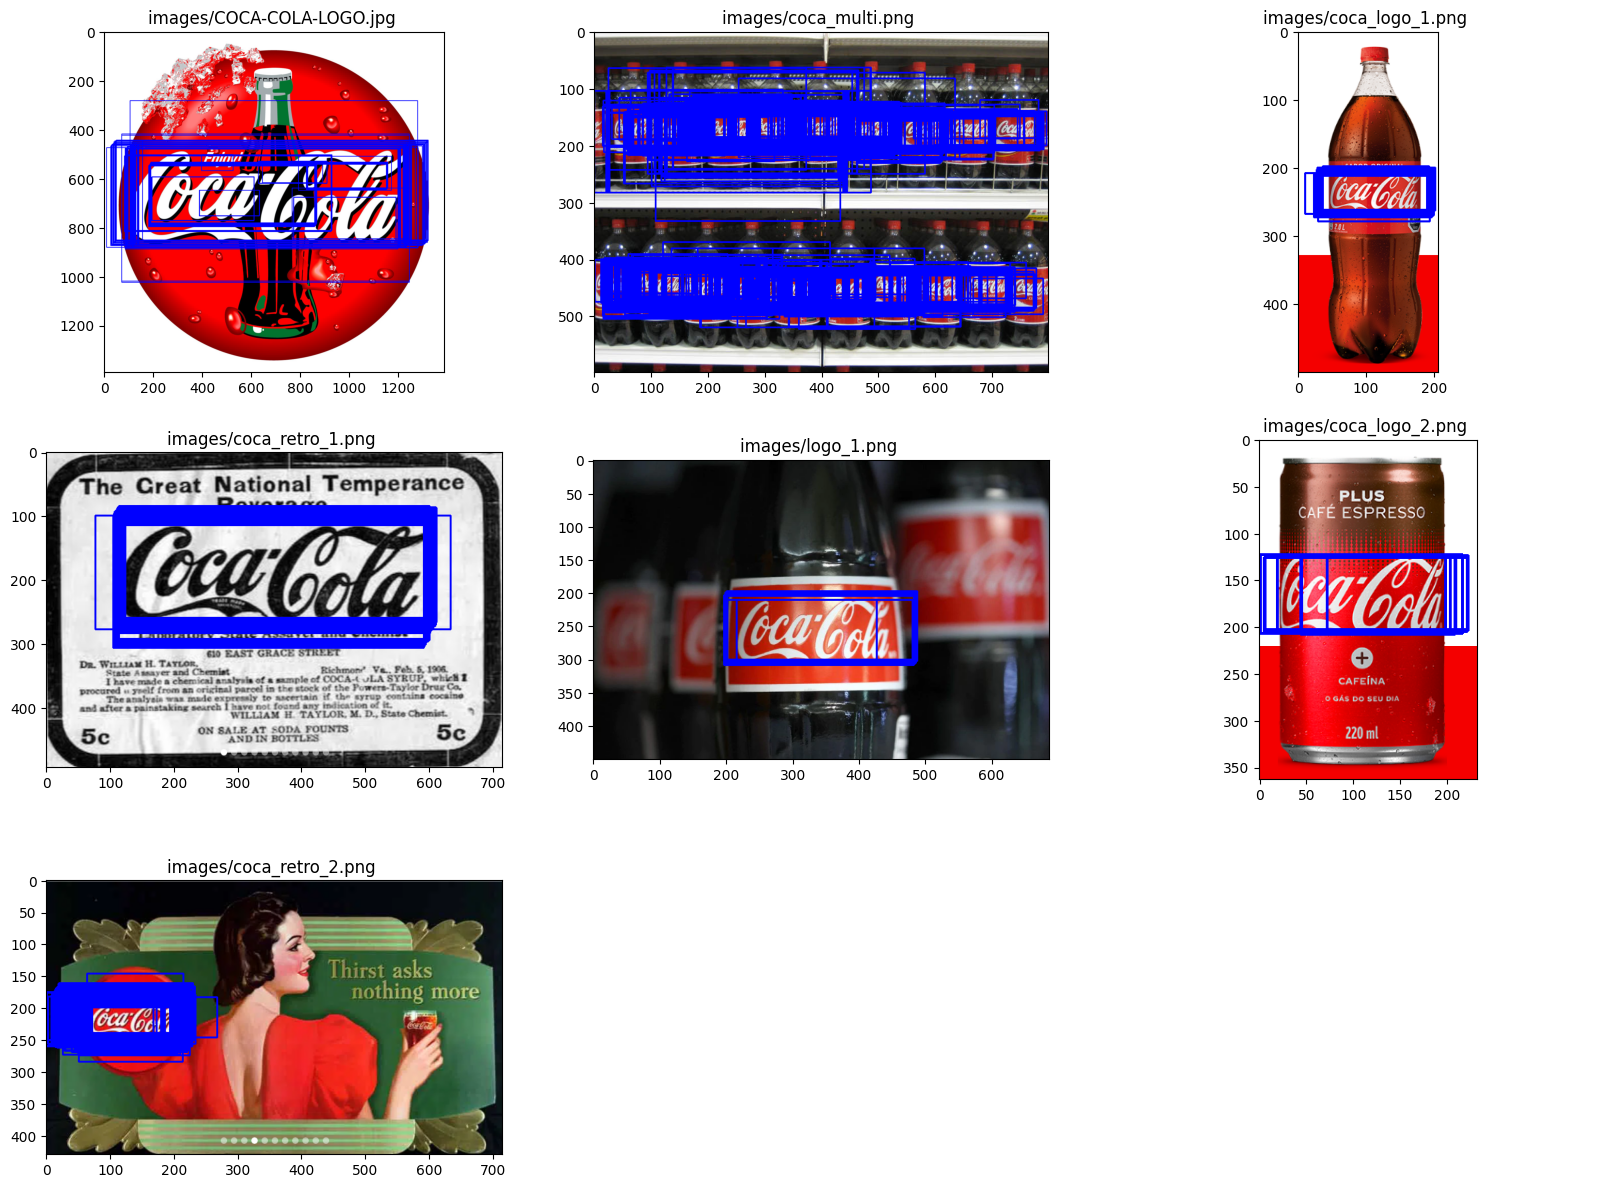

In [335]:
detections = []
for i,img in enumerate(test_images_color):
    print(f'detected image {i}')
    try:
        # detections.append(detect_logo(img, cv.TM_CCORR_NORMED, threshold=0.8))
        detections.append(detect_logo(img, cv.TM_CCOEFF, threshold=0.8))
    except:
        pass
    # detections.append(detect_logo(img, cv.TM_CCORR_NORMED, threshold=0.9))
modified_imgs = list(map(lambda x: x[3], detections))
plot_images(modified_imgs, test_images_paths)

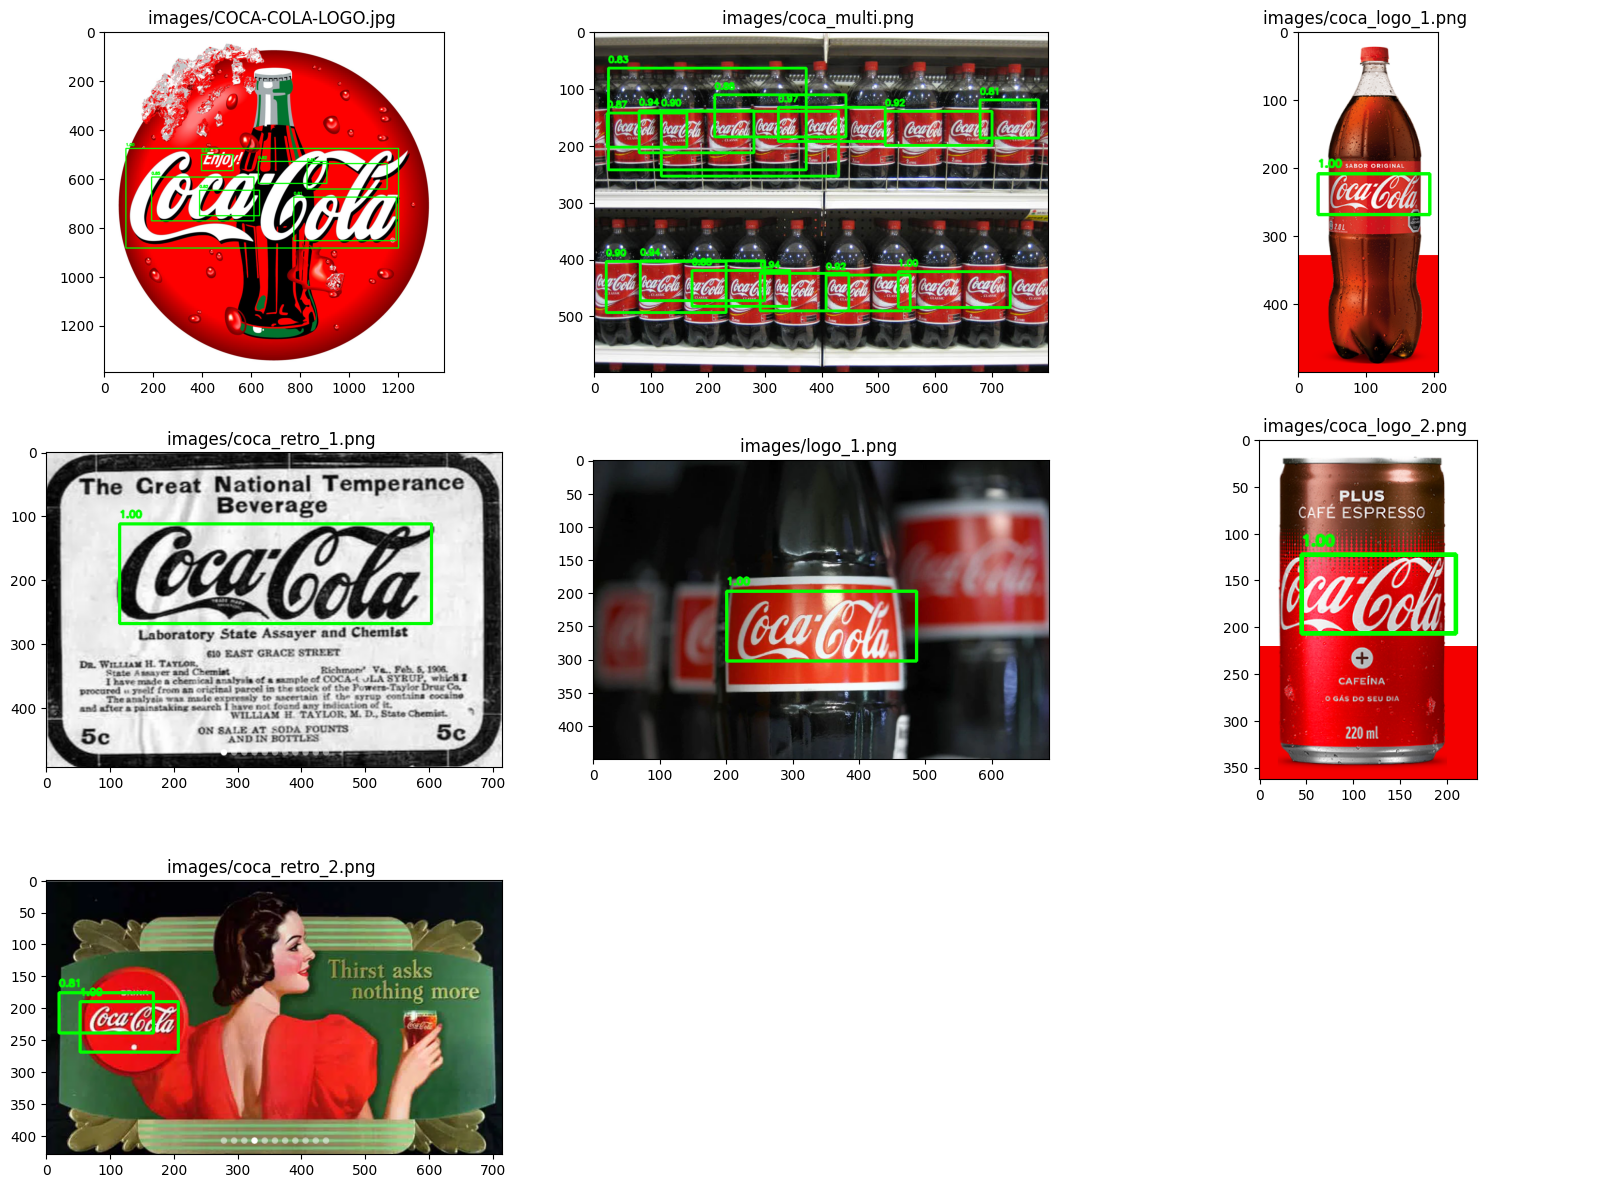

In [336]:
nms_detections = []
for (bbox, scores, normalized_results, modified_image),(original_img) in zip(detections, test_images_color):
    result_img = original_img.copy()
    # print(bbox)
    indices = cv.dnn.NMSBoxes(bboxes=bbox, scores=scores, score_threshold=0.80, nms_threshold=0.5)
    # Filter out the boxes based on the NMS result
    filtered_boxes = [bbox[i] for i in indices.flatten()]
    filtered_scores = [scores[i] for i in indices.flatten()]
    # Draw the filtered boxes on the image
    for (xmin, ymin, xmax, ymax), score in zip(filtered_boxes, filtered_scores):
        cv.rectangle(result_img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
        text = f"{score:.2f}"
        cv.putText(
            result_img, 
            text, 
            (xmin, ymin - 10),  # Position text slightly above the top-left corner of the box
            cv.FONT_HERSHEY_SIMPLEX, 
            0.5,  # Font size
            (0, 255, 0),  # Font color (same as the box)
            2,  # Thickness
            cv.LINE_AA
        )
    nms_detections.append(result_img)
plot_images(nms_detections, test_images_paths)

In [412]:
import imutils
import numpy as np
def normalize(x, xmax, xmin):
    return (x - xmin) / (xmax - xmin)

def detect_logo(image_rgb, method, threshold=0.80):
    template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
    # template_reduced = template[30:-25, 10:-15]
    # template_reduced = template[30:-25, 10:-40]
    edged_template = preprocess_(template)
    
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    tW, tH = gray.shape[::-1]
    found = {}    
    # min_result = 1e20
    # max_result = -1e20
    all_results = np.array([], dtype=np.float32)

    edged = preprocess_(image_rgb)
    plt.imshow(edged, cmap='gray')
    
    for scale in np.linspace(0.2,10,20):
        resized = imutils.resize(edged_template, width=int(edged_template.shape[1] * scale))
        for scale_w in np.linspace(0.5,1,5):
            h,w = resized.shape[:2]
            new_resized = cv.resize(resized, (int(w*scale_w),h))
            if new_resized.shape[0] <= 0.05 * image_rgb.shape[0] or new_resized.shape[1] <= 0.10*image_rgb.shape[1]:
                continue
            if new_resized.shape[0] > image_rgb.shape[0] or new_resized.shape[1] > image_rgb.shape[1]:
                continue
            try:
                result = cv.matchTemplate(edged, new_resized, method)
                found[f'{new_resized.shape[0]},{new_resized.shape[1]},{method}'] = result
                all_results = np.concatenate((all_results, result.flatten()))
                # min_result = min(min_result, np.min(result))
                # max_result = max(max_result, np.max(result))
            except Exception as e:
                pass

    # print(max_result)
    # print(min_result)
    max_result = np.max(all_results)
    min_result = np.min(all_results)
    bbox = []
    scores = []
    for scale_hash, result_scale in found.items():
        normalized_data = normalize(result_scale, max_result, min_result)
        loc = np.where(normalized_data >= threshold)
       
        h, w =[int(el) for el in scale_hash.split(',')[:2]]

        for pt in zip(*loc[::-1]):
            top_left = pt
            startX, startY = top_left[0], top_left[1]
            endX, endY = top_left[0]+w, top_left[1]+h
            cv.rectangle(modified_image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            bbox.append([startX, startY, endX, endY])
            scores.append(normalized_data[top_left[1], top_left[0]])

    return bbox, scores, normalize(all_results, max_result, min_result), modified_image

detected image 0
0.18438984
-1.308872e-06
detected image 1
0.37144557
-7.466753e-07
detected image 2
0.3836673
-4.8045746e-07
detected image 3
0.3337268
-6.8751854e-07
detected image 4
0.31858188
-4.870618e-07
detected image 5
0.36854592
-6.5907807e-07
detected image 6
0.35090312
-1.1601875e-06


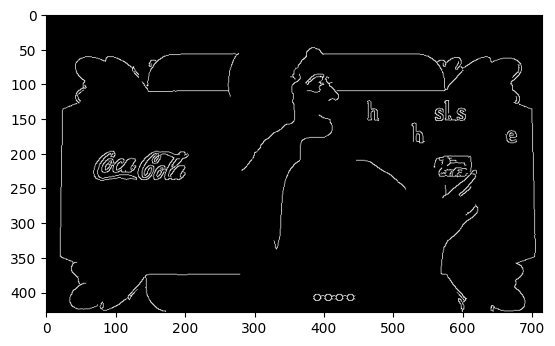

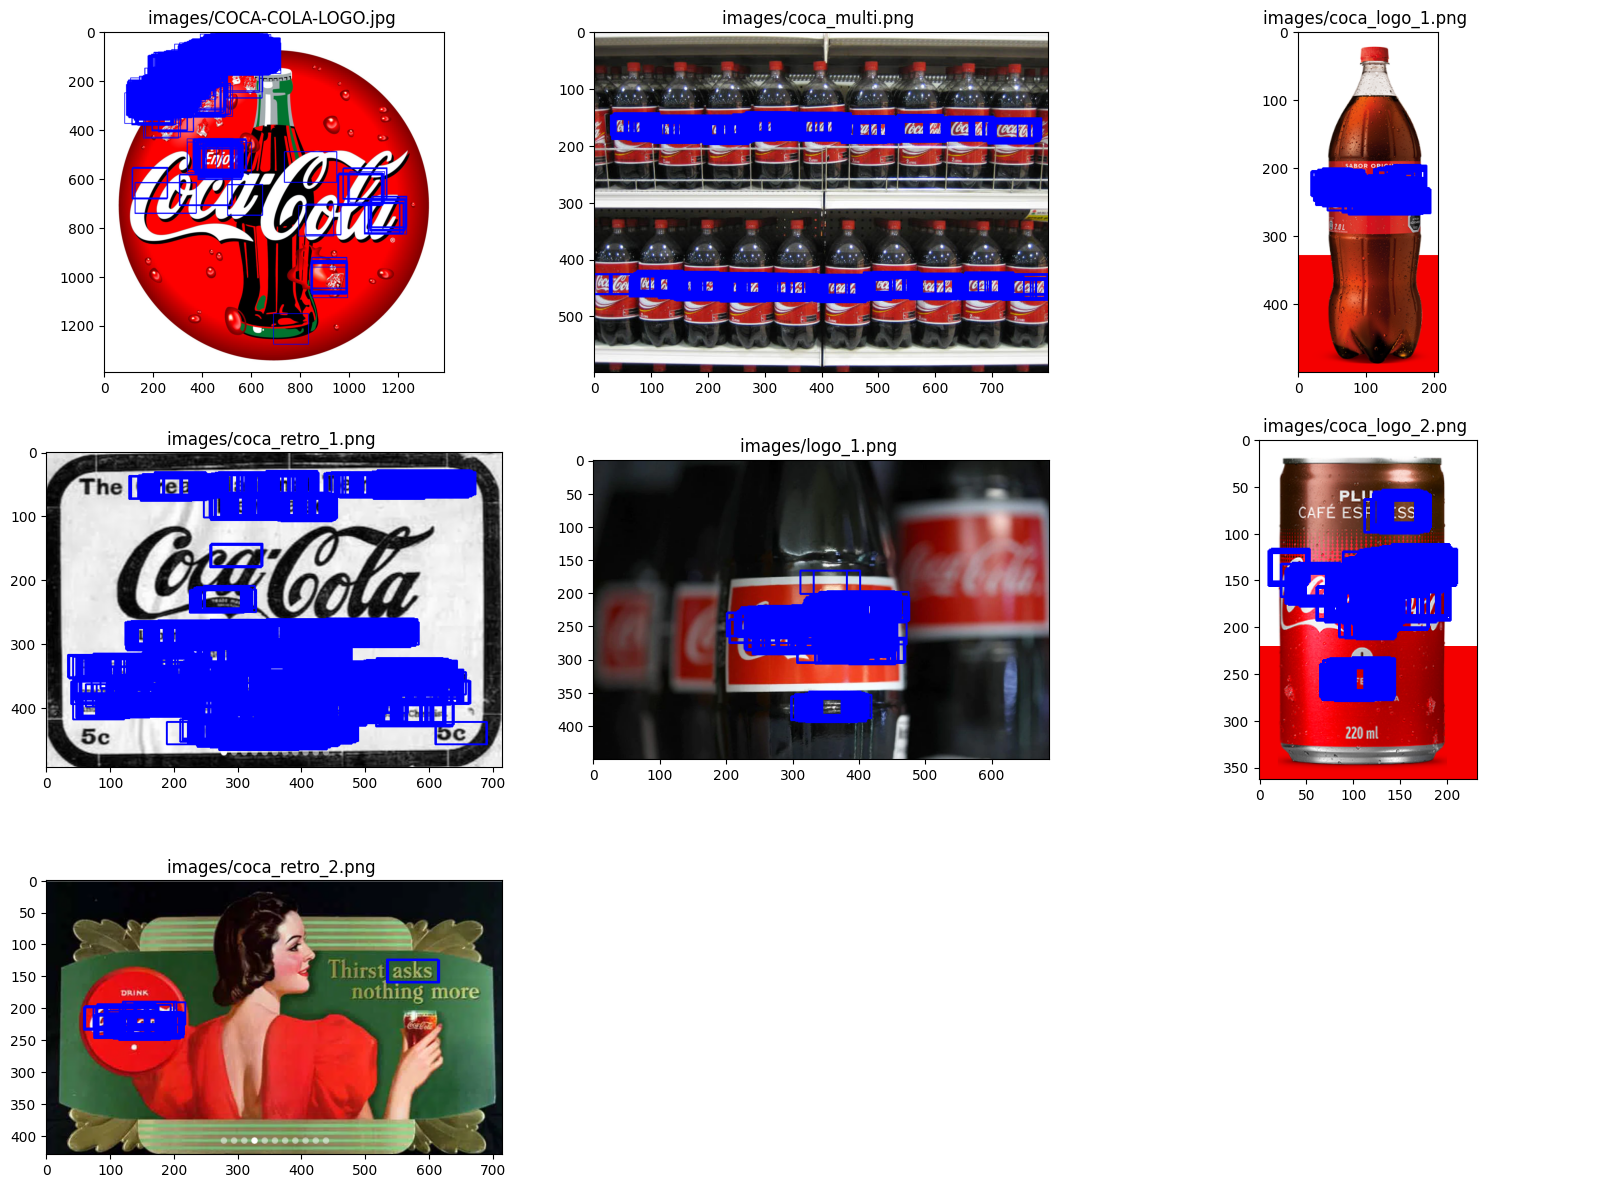

In [413]:
detections = []
for i,img in enumerate(test_images_color):
    print(f'detected image {i}')
    try:
        detections.append(detect_logo(img, cv.TM_CCORR_NORMED, threshold=0.8))
    except Exception as e:
        print(e)
        pass
modified_imgs = list(map(lambda x: x[3], detections))
plot_images(modified_imgs, test_images_paths)